<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>CNN
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellauswahl

CNN spielen eine zentrale Rolle in vielen Deep Learning Architekturen. Zuerst dachten wir, dass im Bereich von Deep Learning mit Textdaten die Transformerarchitekturen CNN's komplett ersetzt haben, doch unser Fachexperte meinte, dass sie immer noch eine Rolle spielen. Um dies zu untersuchen, suchten wir zuerst nach aktuellen Publikationen in diesem Bereich. Wir fanden dabei diverse Publikationen (https://link.springer.com/article/10.1007/s11042-022-13459-x, https://link.springer.com/article/10.1007/s10489-022-04221-9). In diesem Abschnitt möchte wir untersuchen, ob es möglich ist CNN zu verwenden, um eine gute Performance in einem NLP-Klassifikationstask zu erreichen. Eine "gute" Performance wird erreicht, sobald ein höherer F1-Score wie das Baseline-Modell erreicht wird.

## Modellerklärung

Zuerst gibt es Pre-Processing Schritte, diese werden dann in den jeweiligen Kapitel erklärt. Die danach verwendeten Modellarchitekturen in diesem Abschnitt basieren auf 1D-CNN. Im Vergleich zu 2D-CNN wird der Filter nur in eine Dimension verschoben. Eine Dimension ist durch die Inputbreite (Im Beispiel länge 3) bestimmt. Die Kernelgrösse (Im Beispiel 3) könnte auch grösser gewählt werden. Mit einem grösseren Kernel wird ein Bezug von weiter entfernten Wörter gemacht.
Dabei können mehrere 1D CNN hintereinander verwendet werden. Als letzter Layer wird in diesem Abschnitt ein linearer Layer verwendet, um die Dimension auf ein Klasse zu reduzieren. Als letzte Aktivierungsfunktion wird Sigmoid verwendet, um eine Wahrscheinlichkeit der Klassifkation zu berechnen. Als Kostenfunktion wird binary cross entropy verwendet.

![CNN-url](https://cezannec.github.io/assets/cnn_text/conv_maxpooling_steps.gif "CNN 1D")

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import gensim
import gensim.downloader as api
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras.backend as K
from transformers import AutoModel, AutoTokenizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Gensim Version: {gensim.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]
PyTorch Version: 1.12.1+cu116
Numpy Version: 1.26.1
Pandas Version: 2.1.1
Matplotlib Version: 3.6.2
Sklearn Version: 1.1.2
Seaborn Version: 0.13.0
Tensorflow Version: 2.11.0
Gensim Version: 4.3.2


## Einlesen des Verarbeiteten Datensatzes

In [2]:
train = pd.read_csv("./data/processed/train.csv")
val = pd.read_csv("./data/processed/val.csv")
test = pd.read_csv("./data/raw/test.csv")

## Pre-Processing

### Tokens für nicht vortrainierte Embeddings und Word2vec embeddings

Damit die Sätze als Input für die Modelle verwendet werden können, werden sie zuerst vektorisiert. Dies bedeutet, dass pro Wort eine neue Dimension erstellt wird. Jedes Wort steht somit in einem 90° Winkel zu allen anderen Wörtern (solange sie unterschiedlich sind).

In [3]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train.text)

train_tokens = tokenizer.texts_to_sequences(train.text)
val_tokens = tokenizer.texts_to_sequences(val.text)
test_tokens = tokenizer.texts_to_sequences(test.text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories = 1 

print(f"Maximal number of words of sentences {max([len(lst) for lst in train_tokens])}")

maxlen = 40

train_tokens = pad_sequences(train_tokens, padding='post', maxlen=maxlen)
val_tokens = pad_sequences(val_tokens, padding='post', maxlen=maxlen)
test_tokens = pad_sequences(test_tokens, padding='post', maxlen=maxlen)

Maximal number of words of sentences 31


## Nicht vortrainierte Embeddings

Die vorhin erklärt Variante, um Wörter zu vektorisieren hat den Nachteil, dass es sehr viele Dimension gibt. Zudem sind die Vektoren Sparse, da jeweils nur ein Wort eine 1 hat. Darum werden in einem nächsten Schritt diese Vektoren Embedded. Das bedeutet die Wörter werden in weniger Dimension erklärt und ähnliche Wörter haben eine kurze Distanz im Vektorraum. Bei den nicht vortrainierten Embeddings verwenden wir eine Breite von 30 um die einzelnen Wörter zu erklären.

In [4]:
not_pretrained_emb = keras.layers.Embedding(vocab_size, 30, input_length=40)

### Word2Vec embeddings

Es gibt auch vortrainierte Embeddings. Diese haben bereits anhand eines grossen Datensatzes gelernt, welche Wörter, welche Abhängigkeiten haben.

Bei word2vec gibt es zwei Varianten, wie das Modell trainiert werden kann:
- Continuous Bag of Words (CBOW): Hier versucht das Modell, ein Zielwort basierend auf den umgebenden Kontextwörtern vorherzusagen. Es nimmt den Kontext als Eingabe und versucht, das zentrale Wort zu prognostizieren.
- Skip-Gram: Dieser Ansatz funktioniert umgekehrt zum CBOW. Das Modell nimmt ein Zielwort als Eingabe und versucht, die umgebenden Kontextwörter vorherzusagen. Skip-Gram ist besonders effektiv für seltene Wörter.

Dabei gibt es diverse vortrainierte Modelle (https://huggingface.co/models?sort=trending&search=word2vec). Es wurde das Word2vec Modell (https://huggingface.co/fse/word2vec-google-news-300) ausgewählt, welches mittels CBOW anhand der Google News trainiert wurde, da es in diversen Beispielen verwendet wurde. Embeddings welche auf anderen Beispielen trainiert wurde, könnte das Modell verbessern.

In [189]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    unrecognized_words = 0
    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding[word]
        except:
            weight_matrix[i] = np.zeros(300)
            unrecognized_words += 1
    
    print(f"{unrecognized_words} words are not recognized")
    return weight_matrix


# get vectors in the right order
word2vec_google_news = api.load("word2vec-google-news-300")
embedding_vectors = get_weight_matrix(word2vec_google_news, tokenizer.word_index)
embedding_word2vec = keras.layers.Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=40, trainable=True)

9587 words are not recognized


### Bert tweet embeddings

Als weitere Embedding Methode werden die Bert Tweet (https://huggingface.co/docs/transformers/model_doc/bertweet) Word Embeddings verwendet. Dies ist interessant, da diese Embeddings auf Tweets vortrainiert wurden.
Bei Bert werden die Tokens anders erstellt (https://tinkerd.net/blog/machine-learning/bert-tokenization/), darum muss der Tokenizer von Bert verwendet werden. Ein grosser Unterschied ist das Verwenden von Subword Tokenization. Dabei werden Wörter wie "Zielwort" anhand von zwei Tokens repräsentiert, ziel und ##wort.

In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer_bertweet = AutoTokenizer.from_pretrained("vinai/bertweet-base")
embedding_bert_matrix = bertweet.embeddings.word_embeddings.weight
tokens_train_berttweet = np.array([np.array(tokenizer_bertweet.encode_plus(train.text[index],max_length=40,pad_to_max_length=True)["input_ids"]) for index in range(len(train))])
tokens_val_berttweet = np.array([np.array(tokenizer_bertweet.encode_plus(val.text[index],max_length=40,pad_to_max_length=True)["input_ids"]) for index in range(len(val))])

embedding_bert = keras.layers.Embedding(tokenizer_bertweet.vocab_size+1, 768, weights=[embedding_bert_matrix.detach().numpy()], input_length=40, trainable=True)

## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [235]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def plot_confusion_matrix(model,val_tokens=val_tokens):
    y_prediction = model.predict(val_tokens,verbose=False) > 0.5
    disp= ConfusionMatrixDisplay(confusion_matrix(val.target, y_prediction),display_labels = ["no disaster","disaster"])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def example_prediction(model,val_tokens=val_tokens,val_data=val,random_state=45):
    pd.set_option('display.max_colwidth', None)
    val_data["pred"]=model.predict(val_tokens,verbose=False) > 0.5
    return val_data.sample(15,random_state=random_state)
    
def plot_f1_score_loss(history):
    #  "f1-score"
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))

    ax1.plot(history.history['get_f1'])
    ax1.plot(history.history['val_get_f1'])
    ax1.set_ylim(0,1.1)
    ax1.set_title('model f1-score')
    ax1.set_ylabel('f1.score')
    ax1.set_xlabel('epoch')
    ax1.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax1.legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

## CNN Klassifikationsmodelle

### 1 Convolution und MLP

Anhand der Modellarchitektur mit einem CNN mit Kernelgrösse 5 und einer Anzahl Filter von 64, werden unterschiedliche Embeddings getestet. Sowohl vortrainierte Embeddings, wie Word2Vec und Bert Tweet, wie auch nicht vortrainierte Embeddings. Bei allen Modellen wird in einem ersten Durchgang die richtige Anzahl Epochen untersucht. Danach trainieren und validieren wir die Modelle 5 mal, da die CNN- Modelle unterschiedliche Resultate erzielen. In einem ersten Schritt wird darauf geachtet, dass die Modelle konvergieren, eine genauere Analyse von allen Modelle mit dieser Modellarchitektur, wird anschliessend durchgeführt. 

In [154]:
def conv_mlp(embedding,n_epochs=20,return_model=False,train_tokens = train_tokens,val_tokens = val_tokens):
    model = keras.Sequential()
    model.add(embedding)
    model.add(keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=0)
    if return_model:
        return model
    return history

#### Nicht vortrainiertes Embedding

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 30)            586920    
                                                                 
 conv1d_63 (Conv1D)          (None, 33, 64)            15424     
                                                                 
 flatten_68 (Flatten)        (None, 2112)              0         
                                                                 
 dense_58 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 604,457
Trainable params: 604,457
Non-trainable params: 0
_________________________________________________________________
None


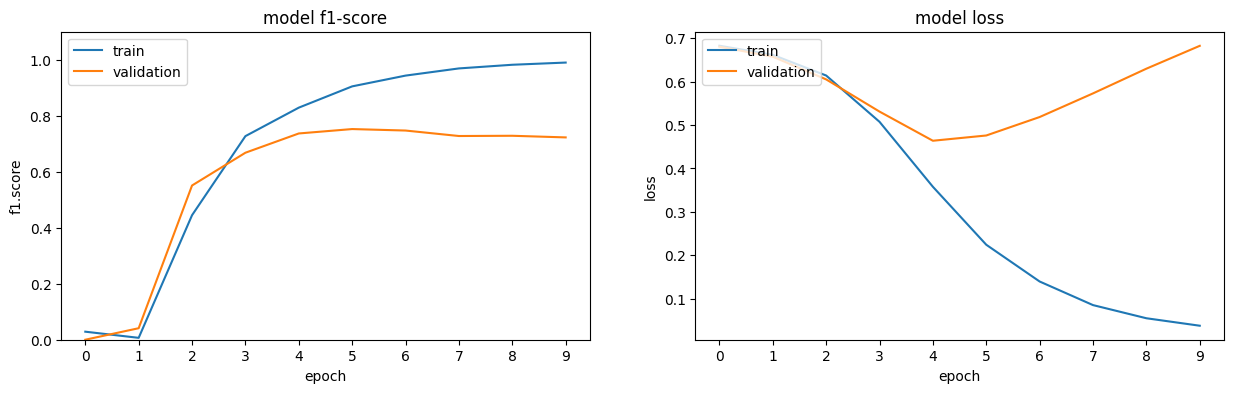

In [172]:
keras.utils.set_random_seed(812)
history = conv_mlp(not_pretrained_emb,10)
plot_f1_score_loss(history)

Der Trainingsloss konvergiert gegen 0. Der F1 Score erreicht ungefähr ein Maximum bei der Epoche 4. Das ist auch die Epoche bei der, der Validation Loss das Minimum erreicht.

In [173]:
# train cnn model 5 times, because the results can be quite different
%%capture
min_loss_not_pre = np.array(history.history["val_loss"]).argmin() +1
# use the minimal loss for model training
not_pretrained_cross5 = [conv_mlp(not_pretrained_emb,min_loss_not_pre).history['val_get_f1'][-1] for n_runs in range(5)]

#### Word2vec Embeddings

Es wird versucht, mit dem Training von CNN-Modellen mittels Word2Vec Embeddings ein besseres Resultat zu erzielen.

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 300)           5869200   
                                                                 
 conv1d_77 (Conv1D)          (None, 33, 64)            153664    
                                                                 
 flatten_82 (Flatten)        (None, 2112)              0         
                                                                 
 dense_72 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 6,024,977
Trainable params: 6,024,977
Non-trainable params: 0
_________________________________________________________________
None


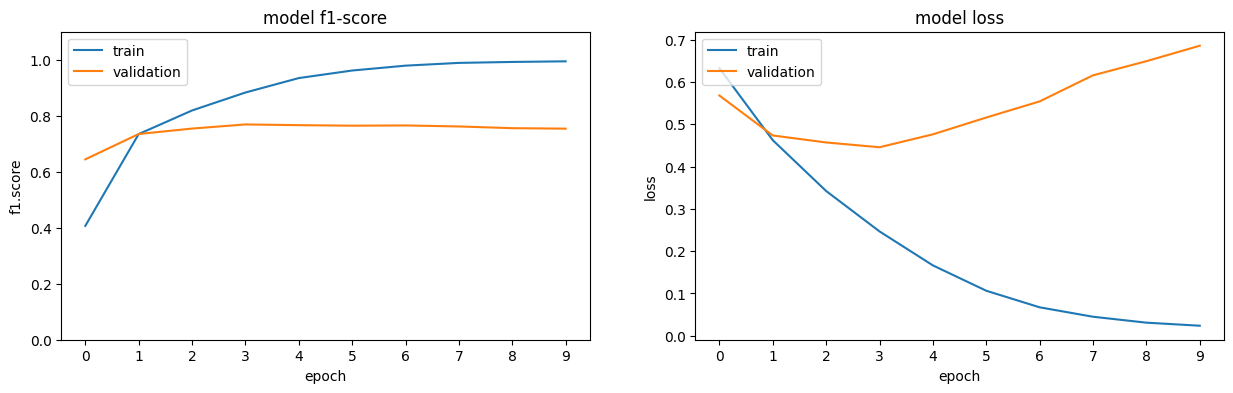

In [190]:
keras.utils.set_random_seed(812)
history = conv_mlp(embedding_word2vec,10)
plot_f1_score_loss(history)

Der Trainingsloss konvergiert gegen 0. Der F1 Score erreicht ungefähr ein Maximum bei der Epoche 3. Das ist auch die Epoche bei der, der Validation Loss das Minimum erreicht.

In [191]:
# train cnn model 5 times, because the results can be quite different
%%capture
min_loss_word2vec = np.array(history.history["val_loss"]).argmin() +1
# use the minimal loss for model training
word2vec_cross5 = [conv_mlp(embedding_word2vec,min_loss_word2vec).history['val_get_f1'][-1] for n_runs in range(5)]

#### Bert-tweet Embeddings
Es wird versucht, mit dem Training von CNN-Modellen mittels Word2Vec Embeddings ein besseres Resultat zu erzielen.

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 768)           49152768  
                                                                 
 conv1d_57 (Conv1D)          (None, 33, 64)            393280    
                                                                 
 flatten_62 (Flatten)        (None, 2112)              0         
                                                                 
 dense_52 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 49,548,161
Trainable params: 49,548,161
Non-trainable params: 0
_________________________________________________________________
None


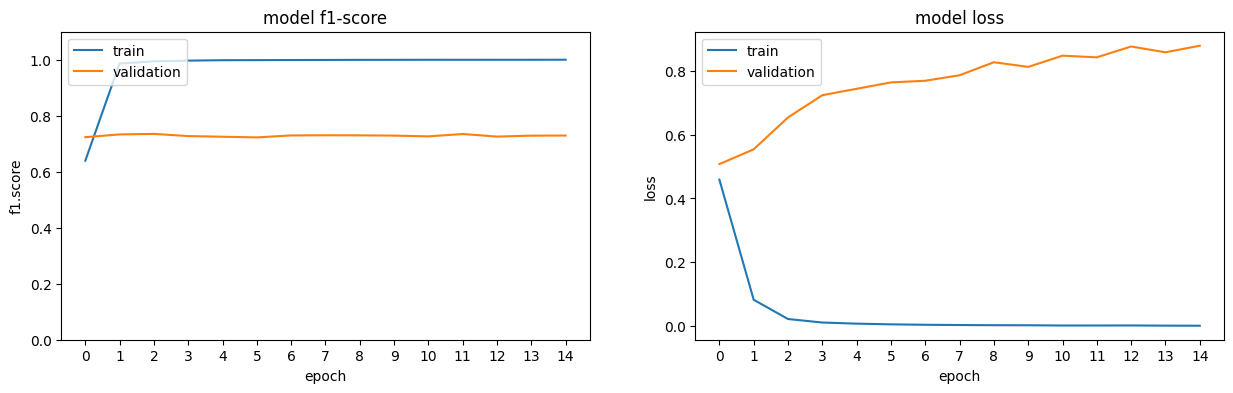

In [169]:
keras.utils.set_random_seed(812)
history = conv_mlp(embedding_bert,15,train_tokens=tokens_train_berttweet,val_tokens=tokens_val_berttweet)
plot_f1_score_loss(history)

Der Trainingsloss konvergiert gegen 0. Der F1 Score erreicht ungefähr ein Maximum bei der Epoche 4. Das ist auch die Epoche bei der, der Validation Loss das Minimum erreicht.

In [170]:
# train cnn model 5 times, because the results can be quite different
%%capture
min_loss_bert = np.array(history.history["val_loss"]).argmin() +1
# use the minimal loss for model training
bert_tweet_cross5 = [conv_mlp(embedding_bert,min_loss_bert).history['val_get_f1'][-1] for n_runs in range(5)]

#### Vergleich

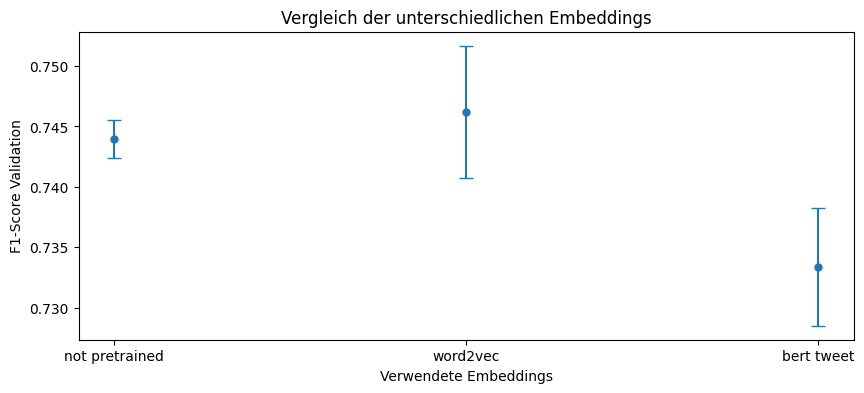

In [192]:
cross_validate = {"not pretrained": not_pretrained_cross5, "word2vec":word2vec_cross5, "bert tweet": bert_tweet_cross5}
fig,ax = plt.subplots(figsize=(10, 4))
ax.errorbar(cross_validate.keys(),np.array(list(cross_validate.values())).mean(axis=1),yerr=np.array(list(cross_validate.values())).std(axis=1),fmt='o',markersize=5, capsize=5)
plt.title("Vergleich der unterschiedlichen Embeddings")
plt.xlabel("Verwendete Embeddings")
plt.ylabel("F1-Score Validation")
plt.show()

Mit den Bert Tweet Embeddings schneidet das Modell am schlechtesten ab. Zudem haben die Modelle je nach initialisierung grosse Unterschiede. Das Modell mit den Word2vec Embeddings schneidet am besten ab, auch wenn es keine Signifikanten Unterschiede zu den nicht vortrainierten Embeddings gibt. Diese Resultate konnten so nicht erwartet werden. Wir sind davon ausgegangen, dass wenn die Embeddings in einem vortrainierten Vektorraum trainiert wurden, die Beziehungen der einzelnen Wörter zueinander klar sind und somit bessere Resultate erzielt werden sollte. 
 

In [ ]:
keras.utils.set_random_seed(812)
model_bert_pred = example_prediction(conv_mlp(embedding_bert,min_loss_bert,return_model=True),tokens_val_berttweet)
model_word2vec = example_prediction(conv_mlp(embedding_word2vec,min_loss_word2vec,return_model=True))
model_not_pre = example_prediction(conv_mlp(not_pretrained_emb,min_loss_not_pre,return_model=True))

In [230]:
models_pred = model_bert_pred.rename(columns={"pred":"pred_bert"})
models_pred["pred_word2vec"] = model_word2vec["pred"]
models_pred["pred_not_pretrained"] = model_not_pre["pred"]

In [231]:
models_pred.reset_index(drop=True).loc[:,models_pred.columns != "id"]

,text,target,pred_bert,pred_word2vec,pred_not_pretrained
0,If you don't have anything nice to say you can come sit with me.,0,True,False,False
1,Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/NhxSe3RTHX,1,True,True,True
2,Vampiro going through the table of flames #UltimaLucha #LuchaUnderground @Elreynetwork http://t.co/Ox6OUw3Yut,0,True,False,False
3,RT kurtkamka: Beautiful desolation. Just me a couple of coyotes some lizards and the morning sun. #Phoenix #ArizÛ_ http://t.co/0z1PvJVdpf,1,True,False,False
4,The thunder shook my house woke my sister and made car alarms go off ????,1,True,False,False
5,#ika #tuning Soup #diet recipes | fat burning soup recipes: http://t.co/8r5vpAoo5z Fat Burning Soup Diet Recip http://t.co/JvcxB75DrJ,0,False,False,False
6,eggs desolate,0,True,False,False
7,2 Injured 1 missing in bridge collapse in central Mexico http://t.co/kHF0iH05A9,1,False,True,True
8,So you have a new weapon that can cause un-imaginable destruction.,1,False,False,False
9,They evacuated the mall. Again. ??,1,True,True,True


Die Modelle mit den Word2Vec embeddings und den nicht vortrainierten Embeddings sind sehr ähnlich.
Die Sätze die sehr offensichtlich sind, wie Nummer 0,1,11 wurden richtig vorhergesagt. Der Satz 3 hätten wir selber als Falsch vorhergesagt. Somit ist es ohne Hintergrundwissen zu dieser Aussage Komplex eine richtige Aussage zu treffen (was das Modell nicht hat). Hingegen der Satz Nummer 8 welcher ziemlich offensichtlich ist wurde von allen Modelle Falsch vorhergesagt.

Das Modell mit den Bert Embeddings hat eine deutlich andere Vorhersage und sagt auch offensichtliche Sätze wie Nummer 7 falsch vorher. Aber das Modell ist besser beim auch eher offensichtlichen Satz Nummer 4. Spannend ist es zu sehen, dass alle Targets richt vorhergesagt wurden, wenn alle Modelle das gleiche Vorhersagen. Dies könnte noch mit allen Sätzen untersucht werden.

Ganz im Allgemeinen kann gesagt werden, dass es diverse Sätze gibt, welche für die Vorhersage schwierig sind und somit auch den F1-Score verschlechtert. Es gibt aber auch offensichtliche Sätze, welche alle Modelle falsch vorhersagen. Somit gibt es Verbesserungspotenzial.
Eine Variante ist, dass Strukturen mit einer grösseren Komplexität nicht abgebildet werden können. Dies wird in einem nächsten Abschnitt mit komplexeren Modellen untersucht.

#### Verständniss der Layer

Das Ziel ist es herauszufinden, welche Filter relevant sind, um den Output zu generieren. Im nächsten Schritt kann dann dieser Filter analysiert werden. Um herauszufinden welche Filter relevant ist, wird analysiert welche Feature Maps (output des CNN Layer) multipliziert mit der Gewichtung, grosse Unterschiede bei der Vorhersage aufweissen. Dies sind die Filter die Entscheiden, was vorhergesagt wird.

In [ ]:
# train modell
not_pretrained_emb = keras.layers.Embedding(vocab_size, 30, input_length=40)
model = conv_mlp(not_pretrained_emb,5, True)
model_for_testing = keras.Sequential()
model_for_testing.add(model.layers[0])
model_for_testing.add(model.layers[1])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 40, 30)            586920    
                                                                 
 conv1d_50 (Conv1D)          (None, 33, 64)            15424     
                                                                 
 flatten_55 (Flatten)        (None, 2112)              0         
                                                                 
 dense_45 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 604,457
Trainable params: 604,457
Non-trainable params: 0
_________________________________________________________________


None


In [ ]:
# predict validation tweets
predicted_values = model.predict(val_tokens)[:,0]
predicted_true = model_for_testing.predict(val_tokens[predicted_values > 0.5])
predicted_false = model_for_testing.predict(val_tokens[predicted_values <= 0.5])

31/31 [==============================] - 0s 1ms/step


In [ ]:
# calculate the weights multiplied by the output of the cnn filter (feature maps) 
weights_mul_cnn_out_false = (predicted_false.reshape(predicted_false.shape[0],2112) * model.get_weights()[3].reshape(-1))
weights_mul_cnn_out_true = (predicted_true.reshape(predicted_true.shape[0],2112) * model.get_weights()[3].reshape(-1))

In [ ]:
# check for decision boundary
assert weights_mul_cnn_out_false.sum(axis=1).max() < weights_mul_cnn_out_true.sum(axis=1).min()

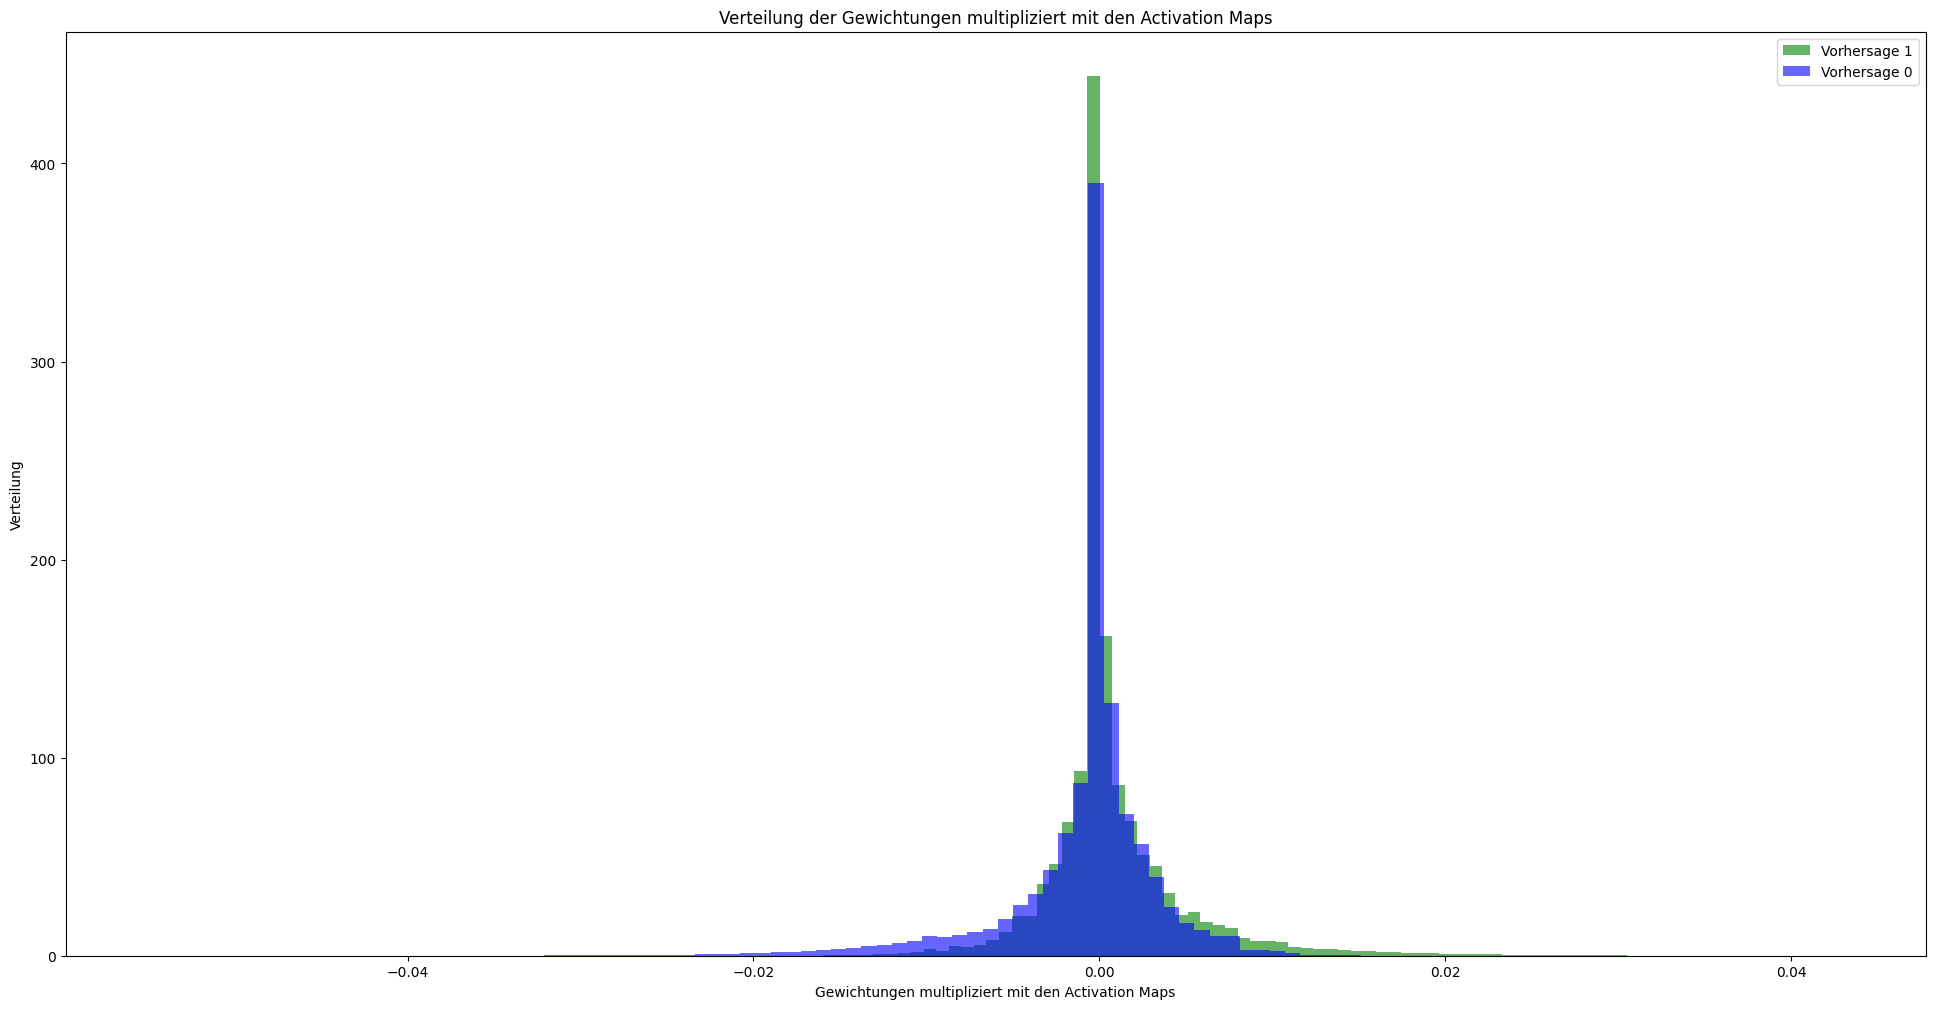

In [ ]:
plt.hist(weights_mul_cnn_out_true.reshape(-1), bins=100, density=True, alpha=0.6, color='g')
plt.hist(weights_mul_cnn_out_false.reshape(-1), bins=100, density=True, alpha=0.6, color='b')
plt.title("Verteilung der Gewichtungen multipliziert mit den Activation Maps")
plt.legend(["Vorhersage 1","Vorhersage 0"])
plt.ylabel("Verteilung")
plt.xlabel("Gewichtungen multipliziert mit den Activation Maps")
plt.show()

Die Meisten sind um 0. Die interessanten sind die Werte in den Randregionen. Die Werte bei der Vorhersage 1 sind höher, wie die mit der Vorhersage 0. Um aussagen über die Randregionen zu machen wird das 0.95 Quantil für die Vorhersagen True berechnet und das 0.05 Quantil für die Vorhersagen False berechnet.
Dadurch kann herausgefunden werden, welche Filter einen Einfluss auf die Vorhersage haben. Im nächsten Schritt wird noch der Durchschnitt berechnet. Dies muss gemacht werden, da es mehr Vorraussagen gibt, welche False vorhergesagt wurden.

Im nächsten Schritt wird dann noch die Differenz der Vorhersagen True und der Vorhersagen False genommen. Dadurch kann bestimmt werden, ob der Einfluss tatsächlich vorhanden ist oder nicht.

In [ ]:
true_095 = (weights_mul_cnn_out_true > np.quantile(weights_mul_cnn_out_true.reshape(-1),0.95)).mean(axis=0).reshape(33,64).mean(axis=0)
false_095 = (weights_mul_cnn_out_false> np.quantile(weights_mul_cnn_out_true.reshape(-1),0.95)).mean(axis=0).reshape(33,64).mean(axis=0)
diff_095 = true_095 - false_095
true_005 = (weights_mul_cnn_out_true < np.quantile(weights_mul_cnn_out_false.reshape(-1),0.05)).mean(axis=0).reshape(33,64).mean(axis=0)
false_005 = (weights_mul_cnn_out_false < np.quantile(weights_mul_cnn_out_false.reshape(-1),0.05)).mean(axis=0).reshape(33,64).mean(axis=0)
diff_005 = true_005 - false_005

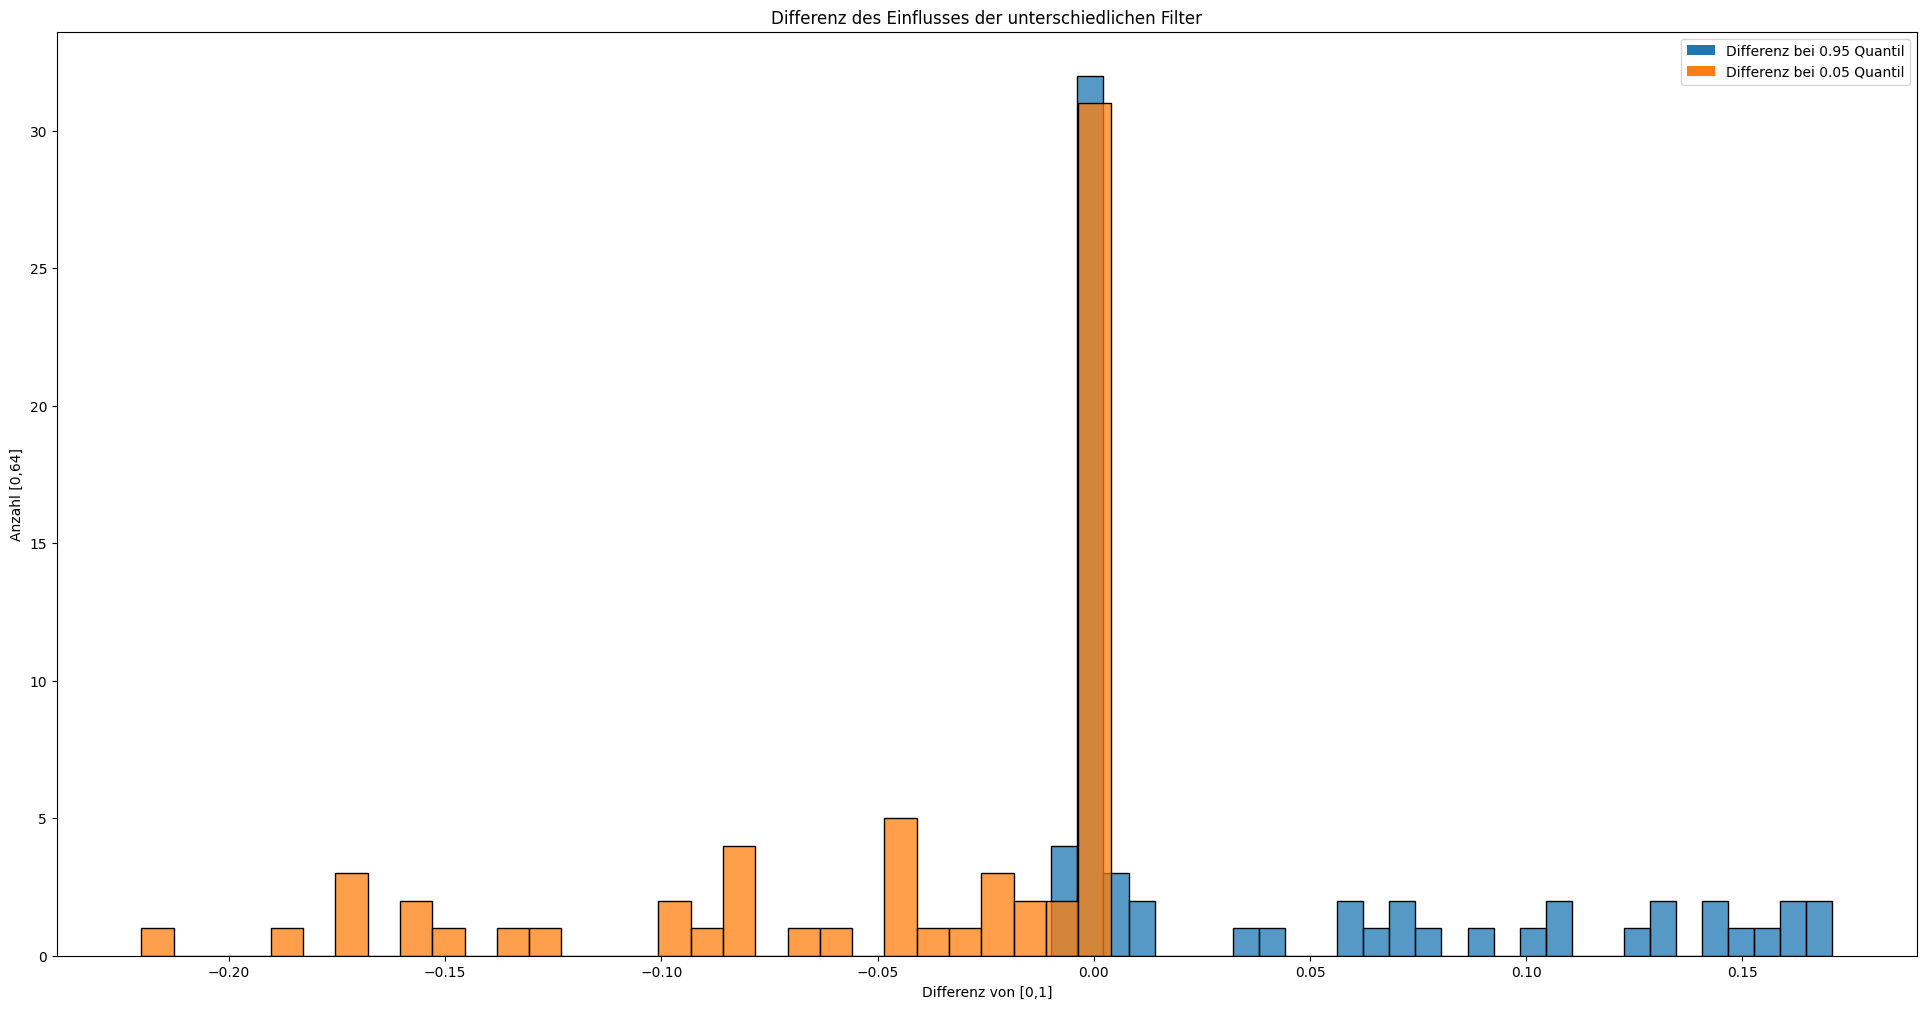

In [ ]:
fig, ax = plt.subplots()

# Plot the histograms without adding a legend
sns.histplot(diff_095, bins=30, label="Differenz bei 0.95 Quantil", ax=ax)
sns.histplot(diff_005, bins=30, label="Differenz bei 0.05 Quantil", ax=ax)

# Collect handles and labels, then create the legend manually
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(l)] for l in unique_labels]

ax.legend(unique_handles, unique_labels)
plt.title("Differenz des Einflusses der unterschiedlichen Filter")
plt.xlabel("Differenz von [0,1]")
plt.ylabel("Anzahl [0,64]")
plt.show()


Etwa die Hälfte der Filter haben kaum einen Einfluss. Ansonsten gibt es ein paar Filter die regelmässig einen Einfluss haben. Es gibt aber keine die immer einen Einfluss haben (Ansonsten Wert 1). In einem nächsten Schritt werden die Filter analysiert die den stärksten Einfluss haben.

In [ ]:
top_3_filter_for_true = np.argsort(diff_095)[-3:]
top_3_filter_for_false = np.argsort(diff_005)[:3]

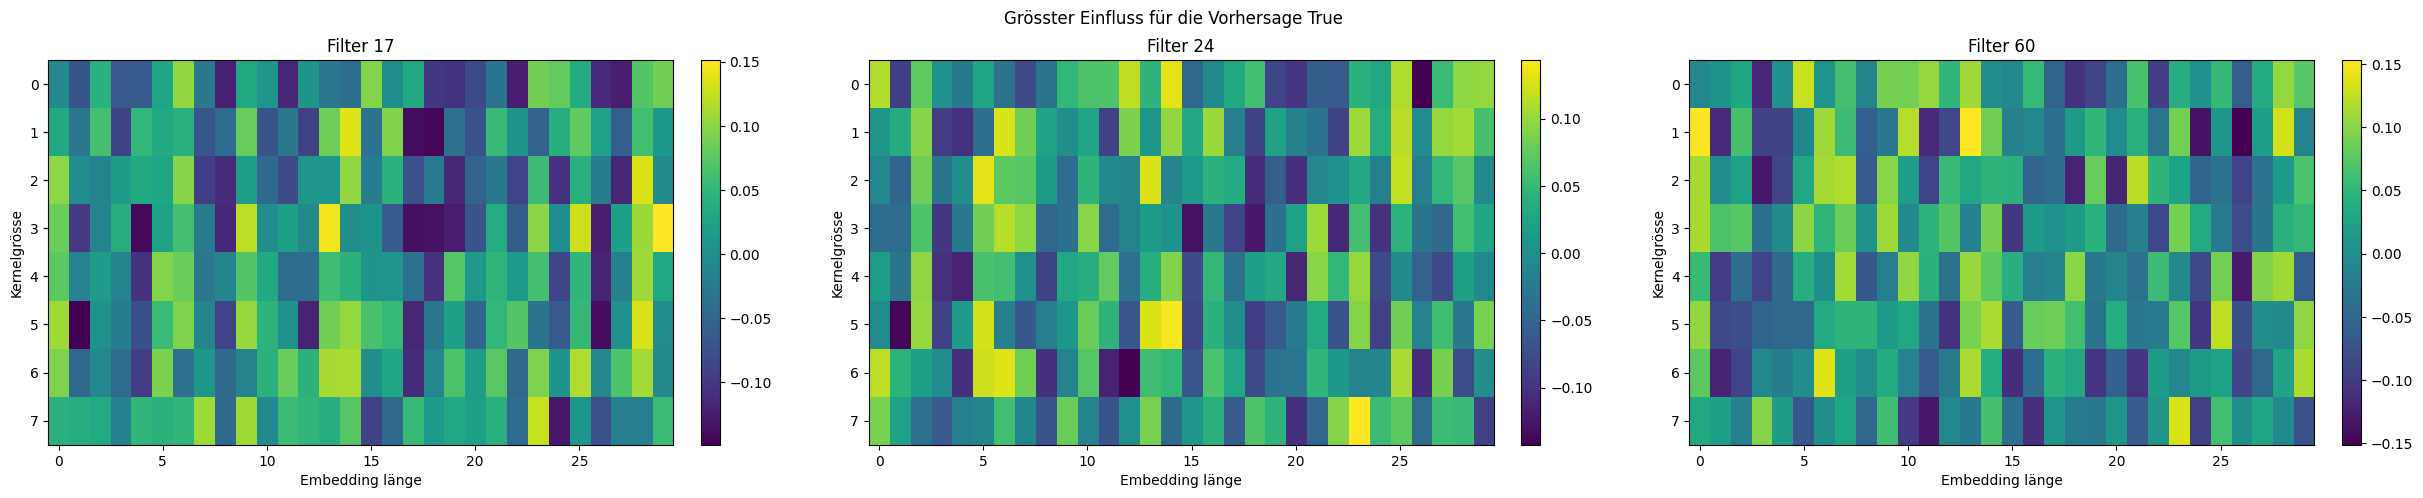

In [ ]:
weights = model.get_weights()[1][:,:,top_3_filter_for_true]
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(3):
    im = axs[i].imshow(weights[:, :, i], aspect='auto')
    axs[i].set_title(f"Filter {top_3_filter_for_true[i]}")
    axs[i].set_xlabel("Embedding länge")
    axs[i].set_ylabel("Kernelgrösse")
    fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
plt.suptitle("Grösster Einfluss für die Vorhersage True")
plt.show()

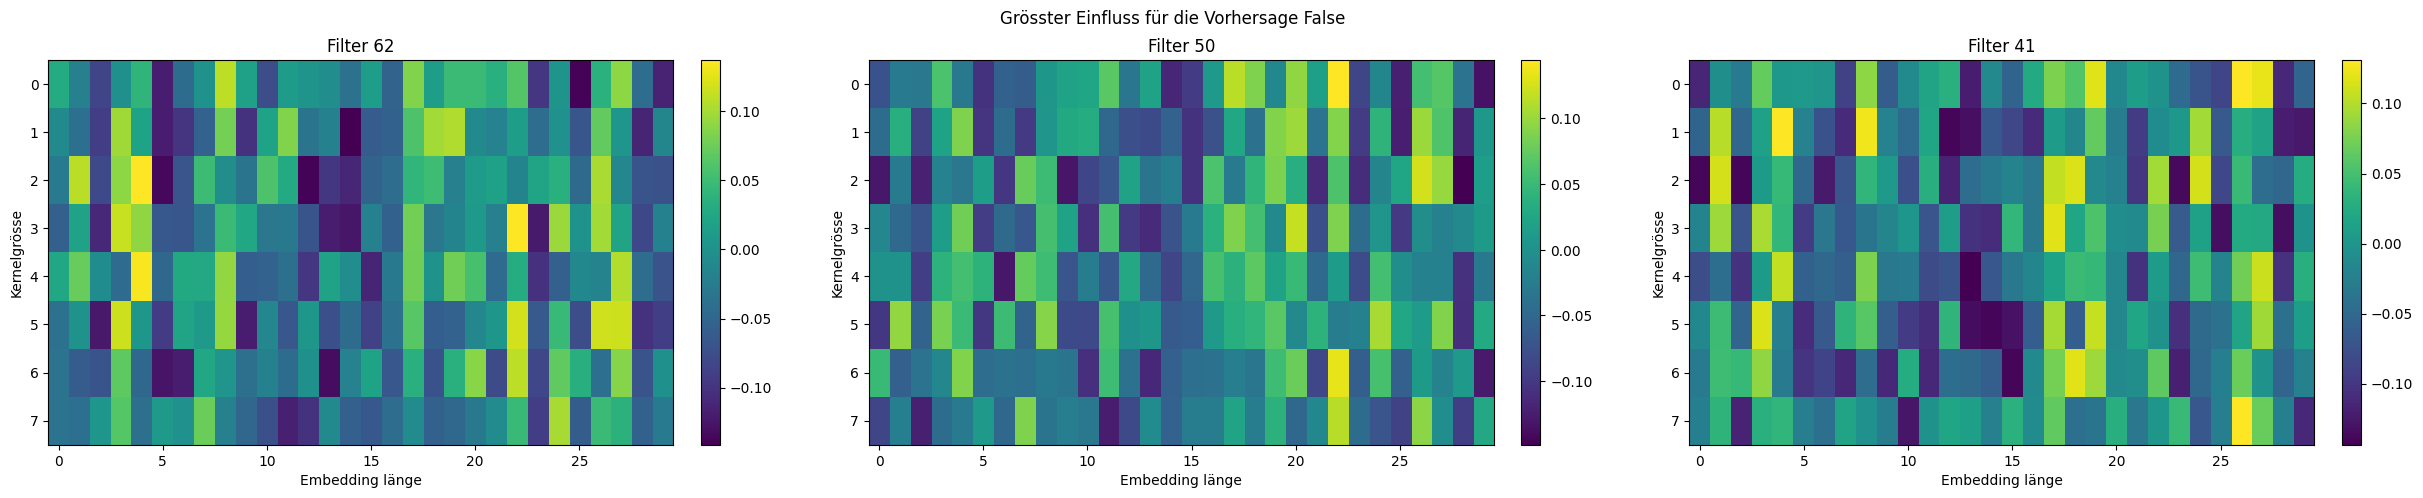

In [ ]:
weights = model.get_weights()[1][:,:,top_3_filter_for_false] 
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(3):
    im = axs[i].imshow(weights[:, :, i], aspect='auto')
    axs[i].set_title(f"Filter {top_3_filter_for_false[i]}")
    axs[i].set_xlabel("Embedding länge")
    axs[i].set_ylabel("Kernelgrösse")
    fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
plt.suptitle("Grösster Einfluss für die Vorhersage False")
plt.show()

Über die Filter kann nur bedingt eine Aussage gemacht werden. Es gibt Auffälligkeiten, wie das Embedding Nr. 30. Da gibt nur tiefe Werte für die Vorhersage True. Ganz im Allgemeinen gibt es leichte Tendenzen, dass die Filter für die Vorhersage True, bei den Embeddings zwischen 0 - 15 höhere Werte annehmen, als bei den Embeddings 15 - 30. Bei den Filter die einen grossen Einfluss für die Vorhersage False haben ist dies umgekehrt. Ob dies Signifikant ist kann nicht gesagt werden.

Für die weiteren Modelle wird diese Analyse nicht mehr gemacht. Es wird zum einen schwieriger, da die Länge der Embeddings grösser ist, zudem konnte nichts offensichtliches erkannt werden.

### Zusätzliche Komplexität
Im nächsten Schritt wird untersucht, ob tiefere und komplexere Modelle bessere Resultate erzielen.
#### 3 convolutions, maxpooling, dropout, 2 mlp

In [216]:
def conv3_mlp2(n_epochs=20,return_model=False):
    model = keras.Sequential()
    model.add(embedding_word2vec)
    model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(20, activation="relu"))
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    print(model.summary())
    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=0)
    if return_model:
        return model
    return history

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 300)           5869200   
                                                                 
 conv1d_90 (Conv1D)          (None, 36, 128)           192128    
                                                                 
 dropout_4 (Dropout)         (None, 36, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_91 (Conv1D)          (None, 16, 64)            24640     
                                                                 
 dropout_5 (Dropout)         (None, 16, 64)            0         
                                                     

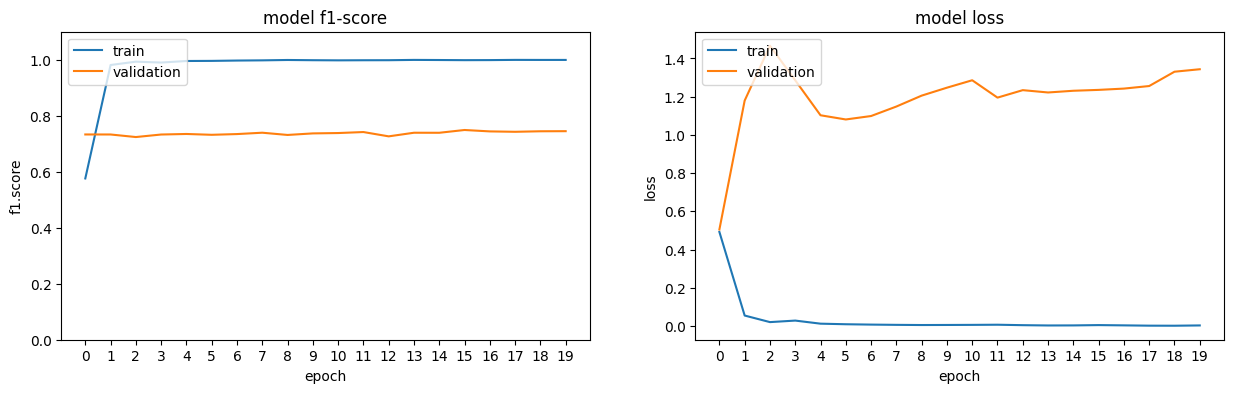

In [210]:
keras.utils.set_random_seed(812)
history = conv3_mlp2()
plot_f1_score_loss(history)

Der Trainingsloss konvergiert gegen 0. Der F1 Score erreicht ein Maximum nach der Epoche 0. Das ist auch die Epoche bei der, der Validation Loss das Minimum erreicht hat. Somit Overfitted das Modell sofort.

In [218]:
# train cnn model 5 times, because the results can be quite different
%%capture
min_loss_3conv_2mlp = np.array(history.history["val_loss"]).argmin() +1
# use the minimal loss for model training
word2vec_cross5_3conv_2mlp = [conv3_mlp2(min_loss_3conv_2mlp).history['val_get_f1'][-1] for n_runs in range(5)]

#### 3 Parallel convolutions

In [217]:
def create_convnet(sent_length, num_classes):
    input_shape =  keras.layers.Input(shape=(sent_length,))
    emb = embedding_word2vec(input_shape)

    tower_1 =  keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(emb)
    #tower_1 =  keras.layers.GlobalMaxPooling1D()(tower_1)
    tower_1 = keras.layers.Flatten()(tower_1)

    tower_2 =  keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu')(emb)
    #tower_2 =  keras.layers.GlobalMaxPooling1D()(tower_2)
    tower_2 = keras.layers.Flatten()(tower_2)

    tower_3 =  keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(emb)
    #tower_3 =  keras.layers.GlobalMaxPooling1D()(tower_3)
    tower_3 = keras.layers.Flatten()(tower_3)

    merged = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
    merged =  keras.layers.Flatten()(merged)

    out =  keras.layers.Dense(50, activation='relu')(merged)
    out =  keras.layers.Dense(num_classes, activation='sigmoid')(out)
    
    model = keras.Model(input_shape, out)
    print(model.summary())
    return model

def parallel3_conf(n_epochs=20,return_model=False):
    model = create_convnet(40,1)
    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=False)
    if return_model:
        return model
    return history

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 40, 300)      5869200     ['input_7[0][0]']                
                                                                                                  
 conv1d_97 (Conv1D)             (None, 36, 256)      384256      ['embedding_7[14][0]']           
                                                                                                  
 conv1d_98 (Conv1D)             (None, 37, 128)      153728      ['embedding_7[14][0]']           
                                                                                            

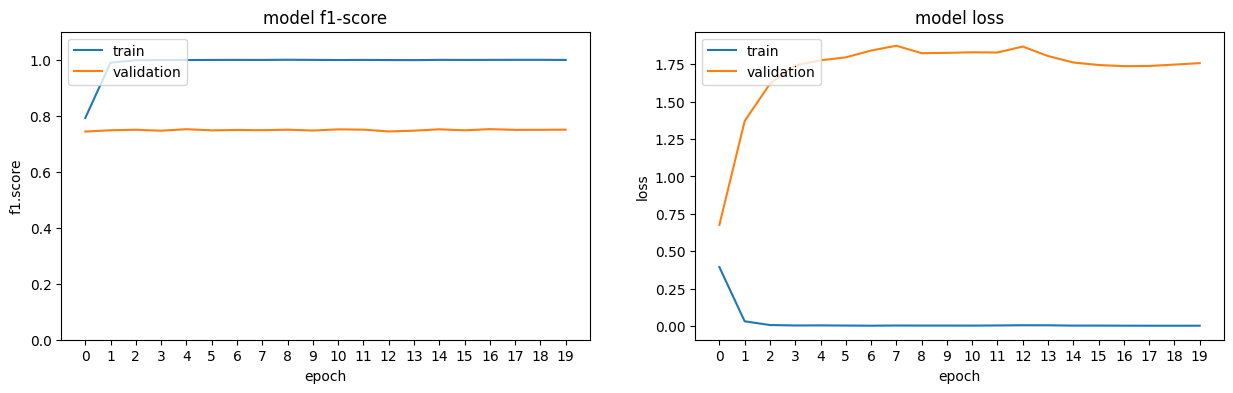

In [213]:
keras.utils.set_random_seed(812)
history = parallel3_conf()
plot_f1_score_loss(history)

Der Trainingsloss konvergiert gegen 0. Der F1 Score erreicht ein Maximum nach der Epoche 0. Das ist auch die Epoche bei der, der Validation Loss das Minimum erreicht hat. Somit Overfitted das Modell sofort.

In [214]:
# train cnn model 5 times, because the results can be quite different
%%capture
min_loss_parrallel3 = np.array(history.history["val_loss"]).argmin() +1
# use the minimal loss for model training
word2vec_cross5_parrallel3 = [parallel3_conf(min_loss_parrallel3).history['val_get_f1'][-1] for n_runs in range(5)]

#### Vergleich Modellkomplexität

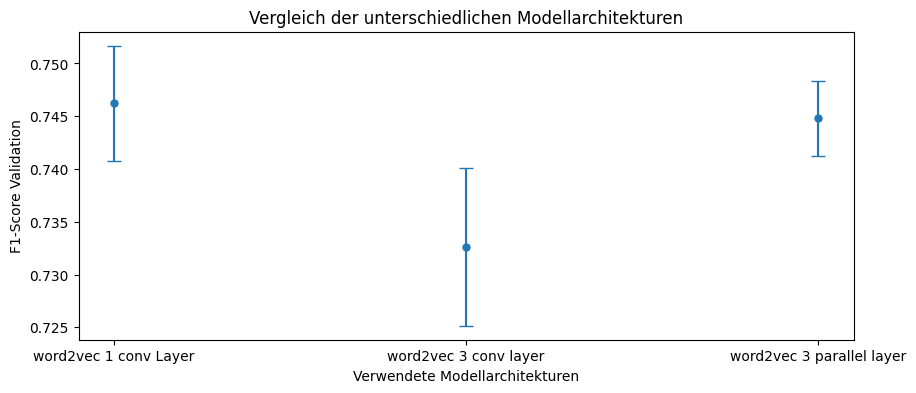

In [241]:
cross_validate = {"word2vec 1 conv Layer": word2vec_cross5, "word2vec 3 conv layer":word2vec_cross5_3conv_2mlp, "word2vec 3 parallel layer": word2vec_cross5_parrallel3}
fig,ax = plt.subplots(figsize=(10, 4))
ax.errorbar(cross_validate.keys(),np.array(list(cross_validate.values())).mean(axis=1),yerr=np.array(list(cross_validate.values())).std(axis=1),fmt='o',markersize=5, capsize=5)
plt.title("Vergleich der unterschiedlichen Modellarchitekturen")
plt.xlabel("Verwendete Modellarchitekturen")
plt.ylabel("F1-Score Validation")
plt.show()

Die Modelle sind ähnlich gut. Einzig das Modell mit den 3 Convolution Layer ist signifikant schlechter (auch wenn nur minimal). Somit werden die Modelle mit steigender Komplexität nicht besser, da sie deutlich schneller overfitten. Das Modell mit den parallen Layer hat zwar weniger Parameter, aber ein besseres Resultat. Es ist aber trotzdem nicht besser, wie das CNN-Modell mit einem Layer.

In [ ]:
keras.utils.set_random_seed(812)
model_word2vec = example_prediction(conv_mlp(embedding_word2vec,min_loss_word2vec,return_model=True),random_state=12)
model_word2vec_3conv_2mlp = example_prediction(conv3_mlp2(min_loss_3conv_2mlp,return_model=True),random_state=12)
model_word2vec_parrallel = example_prediction(parallel3_conf(min_loss_parrallel3,return_model=True),random_state=12)

In [243]:
models_pred = model_word2vec.rename(columns={"pred":"word2vec_base"})
models_pred["word2vec_3conv_2mlp"] = model_word2vec["pred"]
models_pred["word2vec_parrallel"] = model_word2vec_parrallel["pred"]
models_pred.reset_index(drop=True).loc[:,models_pred.columns != "id"]

,text,target,word2vec_base,word2vec_3conv_2mlp,word2vec_parrallel
0,24 killed in two simultaneous rail crash as acute floods derail the two trains #India #mumbai... http://t.co/4KBWPCmMbM,1,True,True,True
1,Reasons I should have gone to Warped today: tony played issues showed up sleeping w sirens played attila is there issues issues issues,1,False,False,False
2,Governor allows parole for California school bus hijacker: Local... http://t.co/tAM6aoskoJ http://t.co/eL24mnFcHw,1,True,True,True
3,Render assistance gain as proxy for your hostages to fortune: sSu http://t.co/KS7Ln8HQ8s,0,False,False,False
4,Don't tell the bride gives me the fear,0,False,False,False
5,//screams in the distance// http://t.co/Cfe9HUQN0h,1,True,True,True
6,Weapons: Twin Knives #OjouBot,0,False,False,False
7,Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called myÛ_ http://t.co/gDjTzkpCHK,1,True,True,True
8,It's going on three years that we have been separated. Sometimes you have to let a man know you will leave him. &amp; that u can survive without,0,False,False,False
9,Youth electrocuted in Khulna | http://t.co/3EnyNdXpPm https://t.co/GQpi7jMKan via @sharethis,1,True,True,True


Die unterschiedlichen Modelle sagen ähnlich vorher und haben somit ähnliche Probleme, wie das Word2vec Base. Dies wurde schon im Vergleich der unterschiedlichen Embeddings aufgeführt. Das beste bisherige Modell war das CNN-Modell mit einem Layer mit den Word2vec Embeddings. Somit untersuchen wir das Modell noch genauer.

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 300)           5869200   
                                                                 
 conv1d_158 (Conv1D)         (None, 33, 64)            153664    
                                                                 
 flatten_163 (Flatten)       (None, 2112)              0         
                                                                 
 dense_153 (Dense)           (None, 1)                 2113      
                                                                 
Total params: 6,024,977
Trainable params: 6,024,977
Non-trainable params: 0
_________________________________________________________________
None


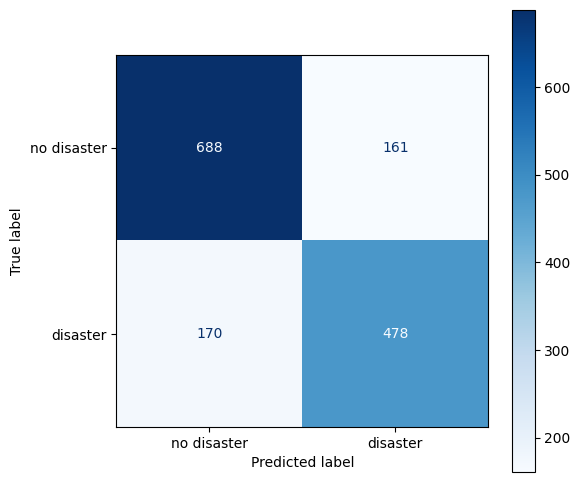

In [246]:
keras.utils.set_random_seed(812)
best_cnn_model = conv_mlp(embedding_word2vec,min_loss_word2vec,return_model=True)
plot_confusion_matrix(best_cnn_model)

Das Modell hat nicht bei einer Klasse mehr Probleme. Somit kann nur gesagt werden, dass das Modell noch nicht optimal abschneidet und dass eine bessere Lösung möglich ist.


Um die Vorhersagen qualitativ zu evaluieren, speichern wir die Vorhersagen und die dazugehörigen Tweets in einer CSV Datei.

In [58]:
val_predictions = []
for tweet, label, prediction in zip(val.text.values, val.target.values, val.pred.values):
    val_predictions.append({
        "tweet": tweet,
        "label": label,
        "prediction": 1 if prediction else 0,
    })

pd.DataFrame(val_predictions).to_csv("data/val_predictions_cnn.csv", index=False)


## Fazit

Die eingesetzten CNN-Modelle erreichten keine besseren Ergebnisse als das Baseline-Modell. Selbst komplexere Architekturen sowie vortrainierte Embeddings brachten nur eine begrenzte Verbesserung der Ergebnisse. Abschliessend lässt sich nicht feststellen, ob alternative CNN-Modellarchitekturen, unterschiedliche Pre-Processing-Methoden oder andere Embeddings zu besseren Resultaten führen würden. Basierend auf den vorliegenden Resultate scheinen CNN-Modelle für diese spezifische Fragestellung nicht vielversprechend zu sein.


## Kaggle Submission

Hier lassen wir noch die Testdaten durch das Modell laufen und speichern die Ergebnisse in einer CSV Datei.
Diese kann bei der Kaggle Competition hochgeladen werden.

In [260]:
test["target"] = (best_cnn_model.predict(test_tokens) > 0.5).astype(int)

test.loc[:,["id","target"]].to_csv("./data/best_cnn_prediction.csv")

  1/102 [..............................] - ETA: 3s

102/102 [==============================] - 1s 9ms/step
